# 1D Heat Equation Using Physics Informed Neural Networks & DeepXDE Library

The equation governing the heat conduction in a one-dimensional rod without any internal heat generation and steady state is given by:

$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} $$

Where:
- $T$ is the temperature of the rod.
- $t$ is time.
- $x$ is the spatial coordinate along the length of the rod.
- $\alpha$ is the thermal diffusivity of the material.

In [7]:
import deepxde as dde
from deepxde.backend import torch
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# Constants:
alpha = 0.4 # m2/s
L = 1 # meter
n = 1 # s

In [9]:
# Define the spatial and time domain:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, n)
# Combine two domains:
geomtime = dde.geometry.GeometryXTime(geometry = geom, timedomain = timedomain)

In [10]:
# Initial condition:
# Temperature distribution at t = 0 is sinusoidal
# on_initial: Apply it only at time t = 0
ic = dde.icbc.IC(geomtime, lambda x: np.sin(n* np.pi * x[:,0:1]/L), lambda _, on_initial: on_initial)

In [11]:
def double_first_column(input_array):
    """Doubles the first column of the input array."""
    return 2 * input_array[:, 0:1]

# Boundary condition
bc = dde.icbc.DirichletBC(geomtime, double_first_column, lambda _, on_boundary: on_boundary)

In [12]:
def pde(comp,T):
    """Defines the PDE in terms of its derivatives."""
    dT_t = dde.grad.jacobian(T, comp, i = 0,j = 1)
    dT_xx = dde.grad.hessian(T, comp, i = 0,j = 0)
    return dT_t - alpha * dT_xx

In [13]:
# Collect PDE, boundary, and initial conditions:
data = dde.data.TimePDE(geomtime,
                       pde,
                       [bc, ic],
                       num_domain = 2540,
                       num_boundary = 80,
                       num_initial = 160,
                       num_test = 2540,
                       )

In [14]:
# Neural network architecture:
net = dde.nn.FNN([2] + [20]*3+ [1], "tanh", "Glorot normal")

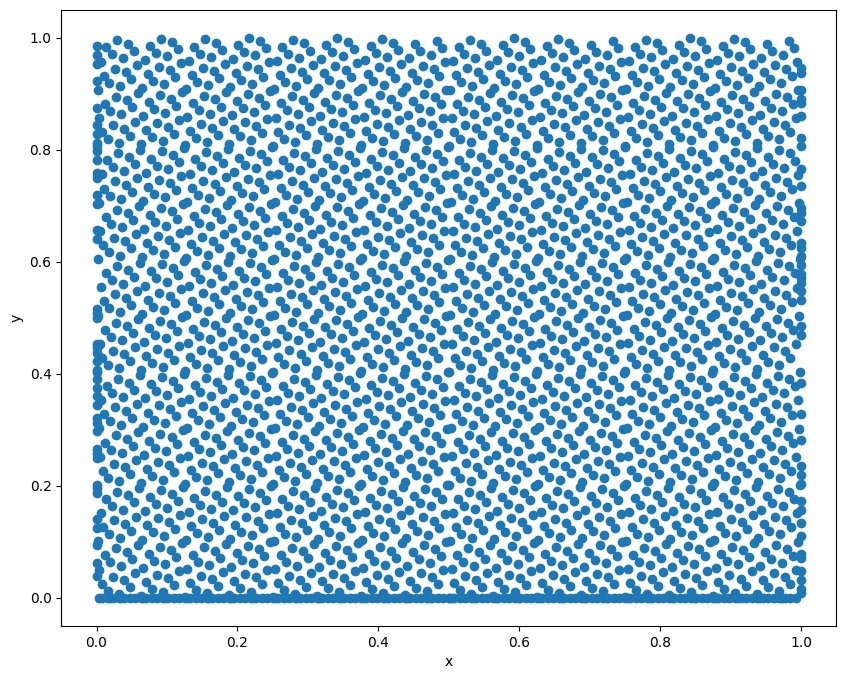

In [15]:
# Visualizing the data points
plt.figure(figsize = (10, 8))
plt.scatter(data.train_x_all[:, 0],data.train_x_all[:, 1])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [16]:
# Model setup:
model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 0.257065 s



In [17]:
# Training using Adam for 15000 iterations
losshistory, train_state = model.train(iterations = 15000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.26e-02, 1.32e+00, 3.18e-01]    [1.10e-02, 1.32e+00, 3.18e-01]    []  


1000      [7.00e-03, 6.81e-02, 1.21e-01]    [4.45e-03, 6.81e-02, 1.21e-01]    []  
2000      [7.18e-03, 4.58e-02, 3.65e-02]    [3.69e-03, 4.58e-02, 3.65e-02]    []  
3000      [4.90e-03, 3.35e-02, 2.32e-02]    [2.03e-03, 3.35e-02, 2.32e-02]    []  
4000      [3.42e-03, 2.69e-02, 1.88e-02]    [1.38e-03, 2.69e-02, 1.88e-02]    []  
5000      [3.18e-03, 2.25e-02, 1.67e-02]    [1.26e-03, 2.25e-02, 1.67e-02]    []  
6000      [2.59e-03, 2.07e-02, 1.43e-02]    [9.52e-04, 2.07e-02, 1.43e-02]    []  
7000      [2.37e-03, 1.89e-02, 1.30e-02]    [8.91e-04, 1.89e-02, 1.30e-02]    []  
8000      [2.57e-03, 1.86e-02, 1.06e-02]    [9.09e-04, 1.86e-02, 1.06e-02]    []  
9000      [2.20e-03, 1.60e-02, 1.11e-02]    [8.41e-04, 1.60e-02, 1.11e-02]    []  
10000     [2.14e-03, 1.49e-02, 1.05e-02]    [8.15e-04, 1.49e-02, 1.05e-02]    []  
11000     [2.08e-03, 1.39e-02, 9.78e-03]    [7.82e-04, 1.39e-02, 9.78e-03]    []  
12000     [3.46e-03, 1.23e-02, 9.96e-03]    [1.55e-03, 1.23e-02, 9.96e-03]    []  
1300

In [18]:
# Training using Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000494 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [1.84e-03, 1.06e-02, 7.10e-03]    [7.71e-04, 1.06e-02, 7.10e-03]    []  
16000     [8.29e-04, 7.29e-04, 6.59e-04]    [5.91e-04, 7.29e-04, 6.59e-04]    []  
17000     [4.01e-04, 1.64e-04, 1.46e-04]    [2.92e-04, 1.64e-04, 1.46e-04]    []  
18000     [1.92e-04, 8.04e-05, 1.11e-04]    [1.55e-04, 8.04e-05, 1.11e-04]    []  
19000     [1.69e-04, 4.03e-05, 5.67e-05]    [1.32e-04, 4.03e-05, 5.67e-05]    []  
20000     [1.37e-04, 3.98e-05, 5.02e-05]    [9.69e-05, 3.98e-05, 5.02e-05]    []  
21000     [1.20e-04, 3.46e-05, 3.43e-05]    [9.63e-05, 3.46e-05, 3.43e-05]    []  
22000     [1.02e-04, 2.76e-05, 2.85e-05]    [8.47e-05, 2.76e-05, 2.85e-05]    []  
23000     [9.09e-05, 2.66e-05, 2.78e-05]    [7.29e-05, 2.66e-05, 2.78e-05]    []  
24000     [7.75e-05, 2.92e-05, 2.53e-05]    [6.13e-05, 2.92e-05, 2.53e-05]    []  
25000     [6.50

Saving loss history to c:\Users\nmert\OneDrive\Data Science\Data Science Journal\datascience_journal\physics_informed_neural_networks\loss.dat ...
Saving training data to c:\Users\nmert\OneDrive\Data Science\Data Science Journal\datascience_journal\physics_informed_neural_networks\train.dat ...
Saving test data to c:\Users\nmert\OneDrive\Data Science\Data Science Journal\datascience_journal\physics_informed_neural_networks\test.dat ...


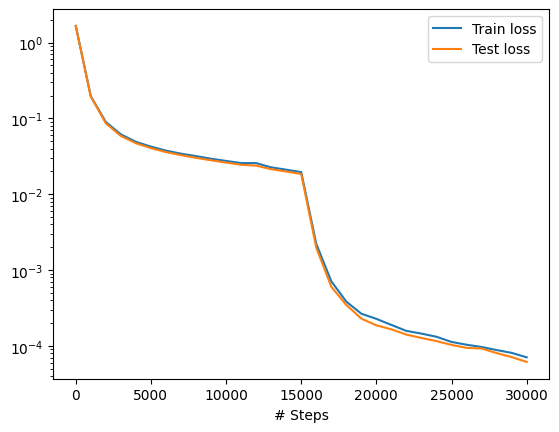

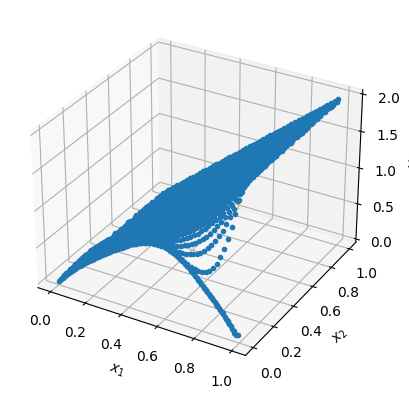

In [19]:
# Save and plot the training progress:
dde.saveplot(losshistory,train_state, issave = True, isplot = True)